In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import subprocess
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


Usamos la GPU para hacer los modelos

In [34]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leemos el Dataset creado con anterioridad

In [35]:
df = pd.read_hdf('BD_Emotios_240324.h5')

Verificamos los datos contenidos

In [36]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[[165, 166, 161], [165, 166, 161], [165, 166,...","[[[62, 83], [62, 88], [62, 93], [63, 97], [64,...","[[[160, 162, 161], [160, 162, 161], [160, 162,...",bored
1,"[[[164, 166, 161], [165, 167, 162], [164, 166,...","[[[62, 83], [62, 87], [62, 92], [63, 96], [64,...","[[[160, 162, 160], [161, 162, 161], [160, 161,...",bored
2,"[[[165, 165, 163], [165, 165, 163], [164, 165,...","[[[63, 82], [63, 87], [63, 91], [64, 96], [65,...","[[[159, 161, 158], [160, 162, 159], [161, 162,...",bored
3,"[[[165, 166, 162], [165, 165, 164], [165, 165,...","[[[63, 83], [62, 87], [63, 92], [63, 97], [65,...","[[[159, 161, 158], [161, 163, 160], [155, 157,...",bored
4,"[[[165, 166, 161], [166, 167, 162], [165, 167,...","[[[63, 83], [63, 87], [63, 92], [63, 96], [64,...","[[[160, 162, 160], [161, 163, 161], [152, 154,...",bored


Checamos la estructura de la mayoría de datos

In [37]:
print(df['Caracteristicas'][0].shape)
print(df['Caracteristicas'][1].shape)
print(df['Caracteristicas'][2].shape)
print(df['Caracteristicas'][3].shape)
print(df['Caracteristicas'][4].shape)

(1, 72, 2)
(1, 72, 2)
(1, 72, 2)
(1, 72, 2)
(1, 72, 2)


Eliminamos cualquier valor que no siga esa estructura. Lo más seguro es que ya no lo cumpla por la forma de haber creado el Dataset, pero uno nunca sabe

In [38]:
# Crear una nueva columna para almacenar solo los registros que cumplan con la forma deseada
df['Caracteristicas_Validas'] = df['Caracteristicas'].apply(lambda x: x if np.array(x).shape == (1, 72, 2) else None)

# Eliminar los registros que no cumplen con la forma deseada
df = df.dropna(subset=['Caracteristicas_Validas'])

# Convertir la columna 'Hitos faciales válidos' en un array NumPy
caracteristicas_valores = np.array(df['Caracteristicas_Validas'].tolist())

# Verificar la forma de X
print(caracteristicas_valores.shape)

(5035, 1, 72, 2)


KNN solo acepta datos en un arreglo, así que le hacemos flatten a cada elemento

In [39]:
caracteristicas_valores = np.array([marcas.flatten() for marcas in caracteristicas_valores])
print(caracteristicas_valores.shape)

(5035, 144)


Los transformamos las Y a etiquetas del 0 al 5 para cada categoria

In [40]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Etiqueta'])

Verificamos que las etiquetas transformadas equivalgan a las clases originales

In [41]:
print("Clases originales:", df['Etiqueta'].unique())
print("Clases codificadas:", label_encoder.classes_)

Clases originales: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']
Clases codificadas: ['bored' 'engaged' 'excited' 'focused' 'interested' 'relaxed']


Hacemos 70% de las muestras en entrenamiento y las 30 en pruebas.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(caracteristicas_valores, y, test_size=0.3, random_state=42)

Verificamos mediante una gráfica la cantidad de vecinos optima

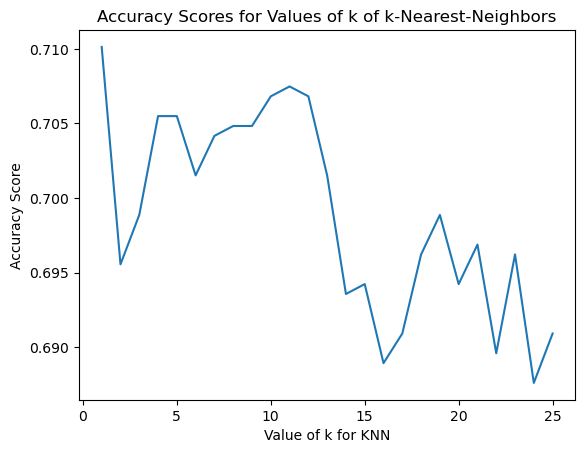

In [43]:
# experimenting with different n values
k_range = list(range(1,26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

Entrenamos el modelo con un numero de vecinos y con los datos de entrenamiento

In [44]:
knn_clf = KNeighborsClassifier(n_neighbors=7)
knn_clf.fit(X_train, y_train)
print("Entrenamiento completado.")

Entrenamiento completado.


Hacemos una predicción y que tanta exactitud tiene el modelo

In [45]:
# Realizar predicciones en el conjunto de prueba
y_pred = knn_clf.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.7041694242223693


Guardamos el modelo

In [46]:
import joblib
# Guardar el modelo
joblib.dump(knn_clf, 'modelo_knn.pkl')

['modelo_knn.pkl']

Cargamos el modelo

In [47]:
# Cargar el modelo
knn_loaded = joblib.load('modelo_knn.pkl')



Usamos el modelo para verificar que sigue funcionando

In [48]:
# Utilizar el modelo cargado para hacer predicciones
predicciones = knn_loaded.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, predicciones)
print("Accuracy del modelo KNN:", accuracy)

Accuracy del modelo KNN: 0.7041694242223693
